# Replicating the Paper with Crypto
 
 - Replicating the paper but using cryptocurrency data instead of traditional currency.
 
## Contents
- [Read Data](#first-bullet)
- [Correlation Matrix](#second-bullet)
- [Eigenspectra](#third-bullet)
- [Cluster Structure](#fourth-bullet)
    - Threshold method
    - Spectral clustering
- [Minimal Spanning Trees](#fifth-bullet)

## Read Data

In [44]:
import pandas as pd
import numpy as np
import sklearn as sk
import random
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from sklearn.cluster import SpectralClustering
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import squareform

exch_dat = pd.read_csv('../data/GoldCrypto.csv')
exch_dat.index = exch_dat['YYYY/MM/DD']
exch_dat = exch_dat.drop(['Unnamed: 0','YYYY/MM/DD'], axis=1)

In [32]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Correlation Matrix

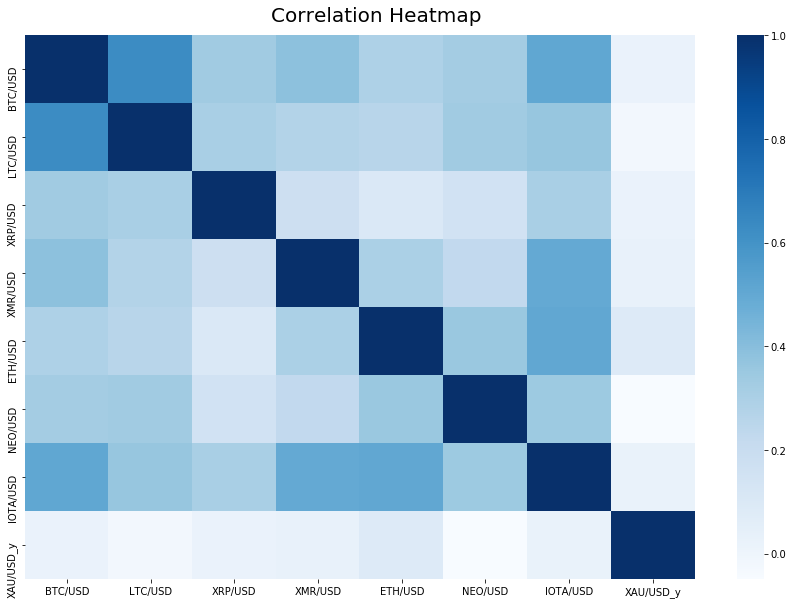

In [33]:
exch_logrets = np.log(exch_dat) - np.log(exch_dat.shift(1))
exch_logrets = exch_logrets.iloc[1:,:]
C = exch_logrets.corr()  # only for x/USD
#C[C.isna()] = 0  # still some NAs in data

#Heatmap of Corr
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle("Correlation Heatmap", fontsize=20, x=.45, y=.92)
sns.heatmap(C, cmap="Blues", xticklabels=C.columns, yticklabels=C.columns);
plt.show();

## Eigenspectra

In [34]:
eigvals, eigvecs = np.linalg.eig(C)
eigvals.sort()

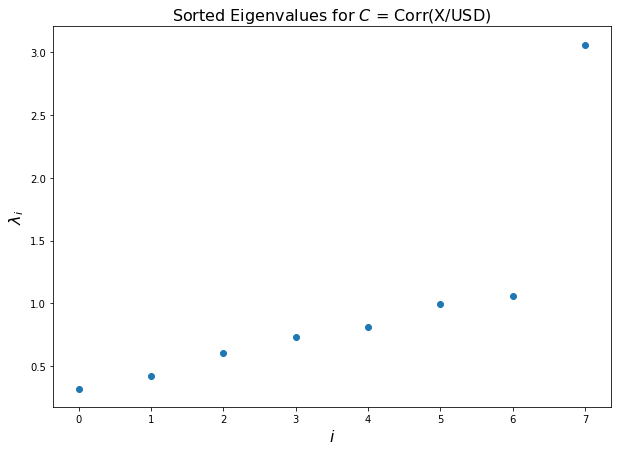

In [35]:
plt.figure(figsize=(10, 7))
plt.scatter(y=eigvals, x=range(0, len(eigvals)))
plt.title('Sorted Eigenvalues for $C$ = Corr(X/USD)', fontsize=16)
plt.xlabel('$i$', fontsize=16)
plt.ylabel('$\lambda_i$', fontsize=16)
plt.show();

This agrees with what the paper has for USD at least. Most all of the eigenvalues are really close to zero. This is just showing that USD is a very interconnected currency. We would expect other base currency correlation matrices to have bigger eigenvalues.

The paper then also finds the residuals of the regression,

$$
G_X^B(t) = \beta G_Y^B(t) + \alpha + \epsilon_X^B(t), \quad i = 1,...,N-1
$$

in order to reduce the influence of USD and EUR on all the other base currency networks. I think we would need to do this with BTC when we move to cryptocurrencies. In our current data we only have x/USD so there is no need to do this. 

## Cluster Structure 
In the paper all they do is find some threshold $p_c$ and zero-out all entries in $C$ that are not greater than it. They do this for many $p_c$'s to find ones that give reasonable clusters based on geography or economic reasoning. This seems pretty weird to me and I think this would be a great time to add in spectral clustering. I will start with their method just for completeness though.
### Thresholding $C$ Method (bad)

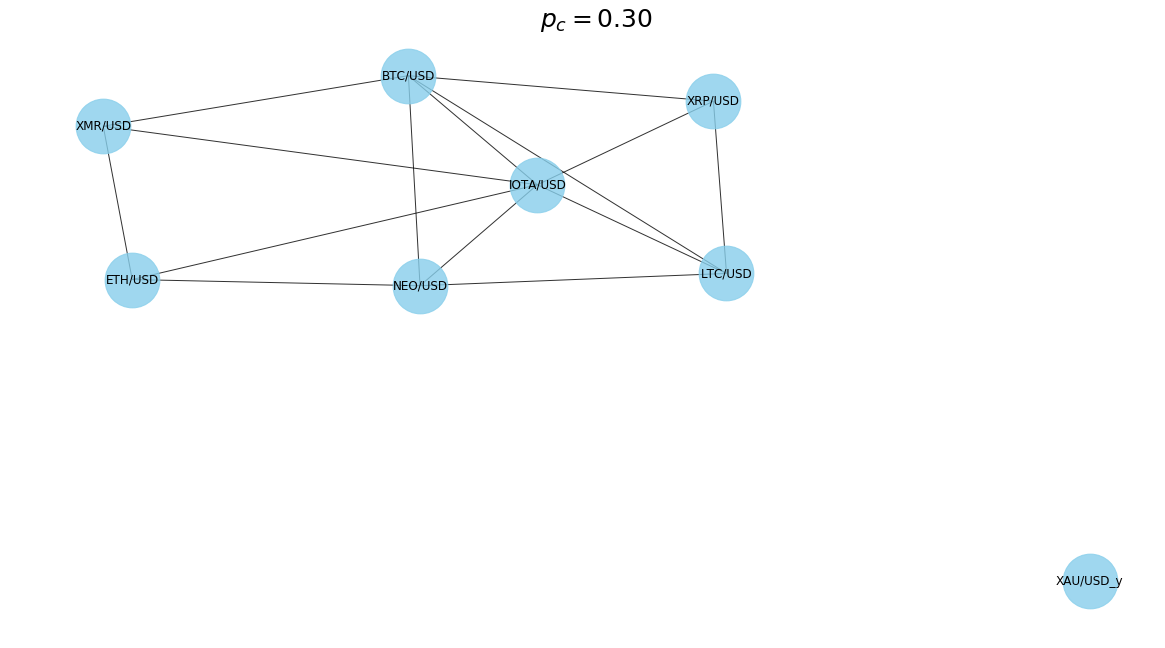

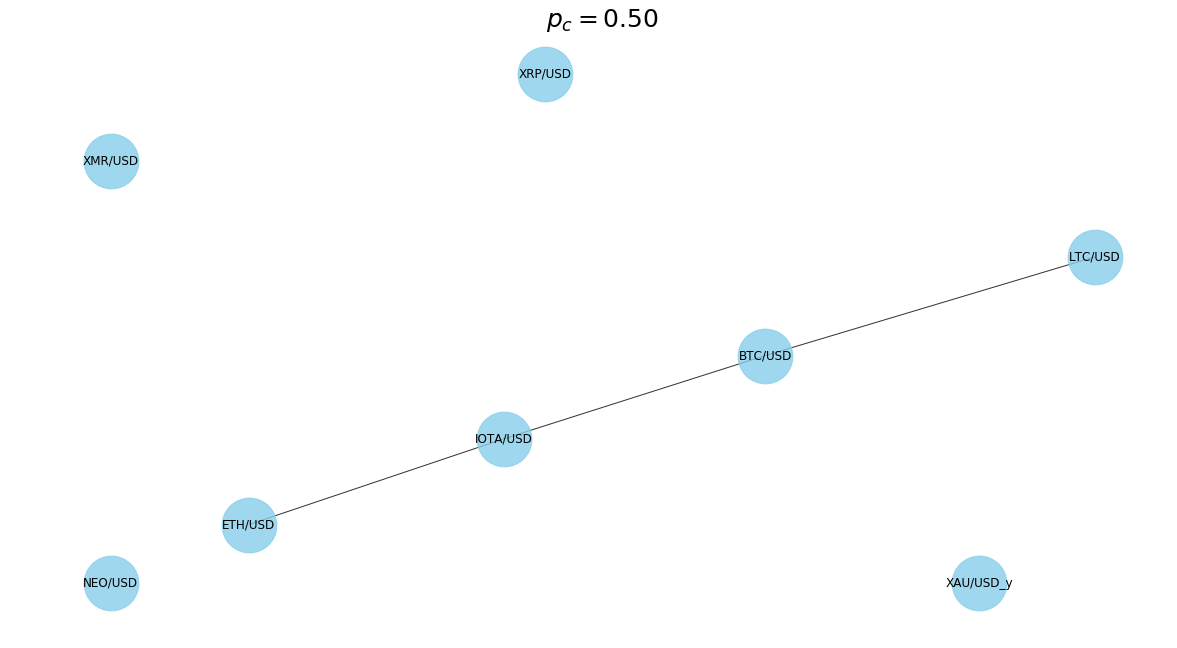

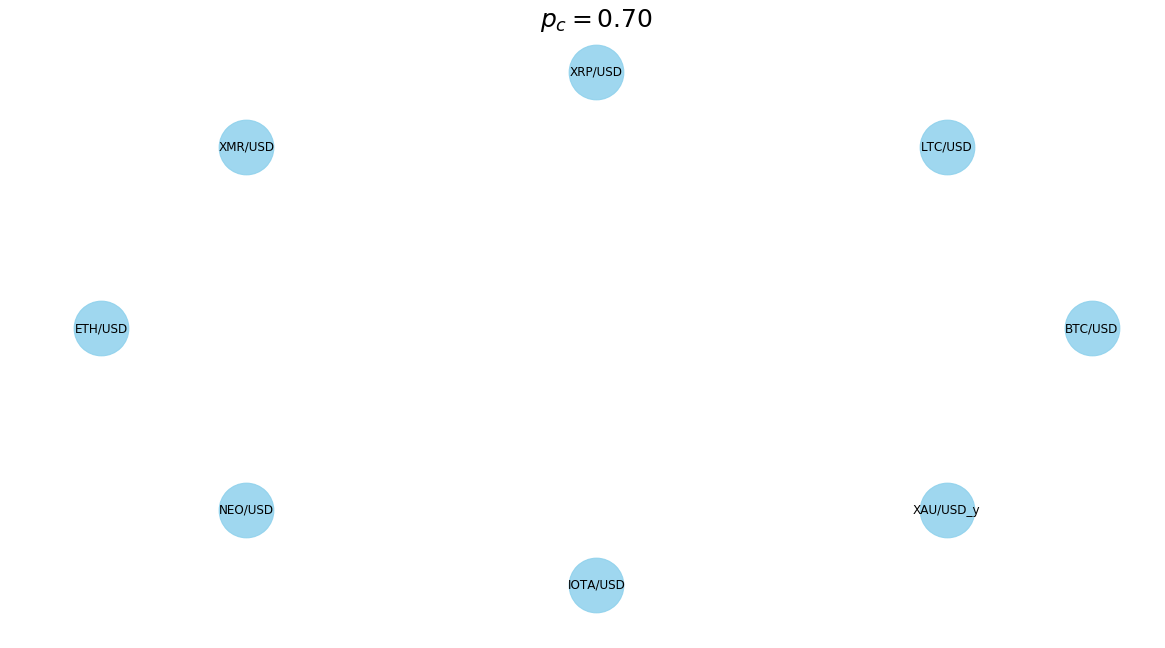

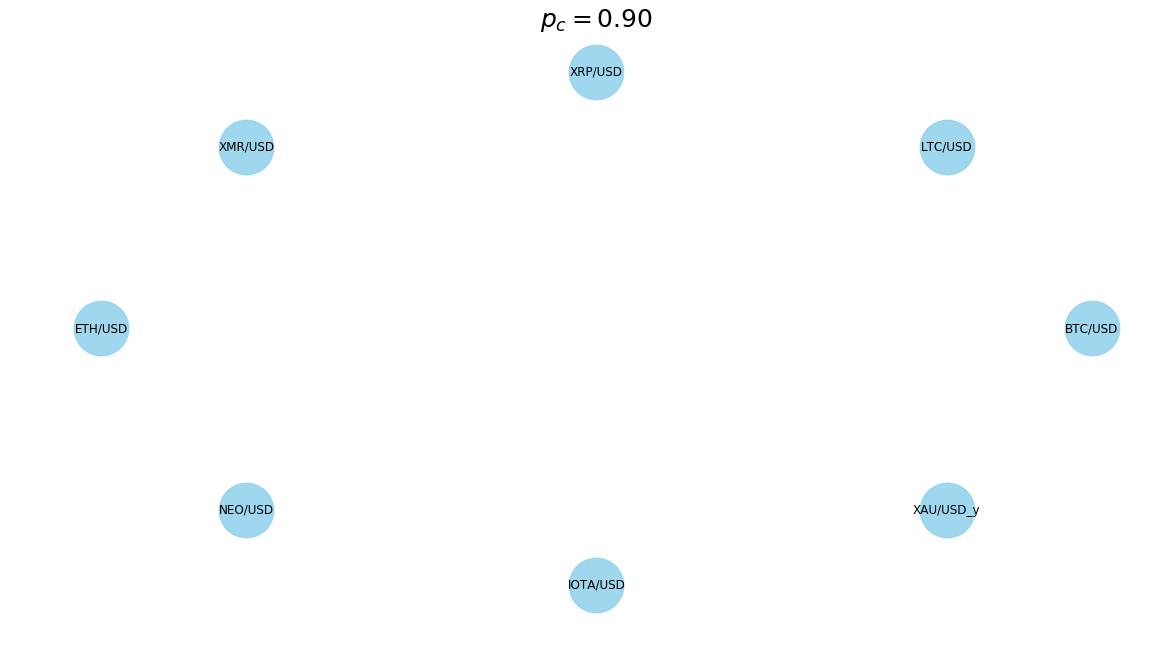

In [36]:
pcs = range(3, 10, 2)  # range parameter will take divided by 10

C_thresh = C.copy()  # copy it so we can alter it
labels = {}
for j in range(len(C_thresh.columns)):
    labels[j] = C_thresh.columns[j]


ttl = "Networks as $p_c$ ranges in [0.30, 0.90]"
fig.suptitle(ttl)
for plot_i, thresh_i in zip(range(len(pcs)), [x / 10 for x in pcs]):
    C_thresh = C.copy()  # copy it so we can alter it
    C_thresh[C_thresh < thresh_i] = 0
    C_thresh -= np.identity(C_thresh.shape[0])
    C_thresh = np.array(C_thresh)
    fig = plt.figure(figsize=(20, 50))
    fig.add_subplot(len(pcs), 1, plot_i + 1)
    
    G = nx.Graph(C_thresh)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, with_labels=False, node_size=3000, 
        node_color="skyblue", node_shape="o", 
        alpha=0.8, pos=pos)
    nx.draw_networkx_labels(G,pos,labels)
    plt.title('$p_c=$' + str(thresh_i) + "0", fontsize=25)
    plt.show()


You can see that as $p_c$ increases the periphery has more and more vertices in its membership, there are more nodes that are not connected to anything. To me this method doesn't really make a lot of sense for clustering. It seems to be a pretty coarse way of determining "like" groups of rates. I think spectral clustering might do better and that is what I try next.

### Spectral Clustering 
I think $\texttt{empirical_evaluation_of}$ $\texttt{_similarity_measures_for_time_series.pdf}$ has a few good ways to specify the distance matrix $D$ that could be cool. At first I just used the $D$ distance matrix they used in the paper we are replicating and threw it into $\texttt{sklearn.cluster.SpectralClustering}$ without much thought.

__First Pass at Spectral Clustering__

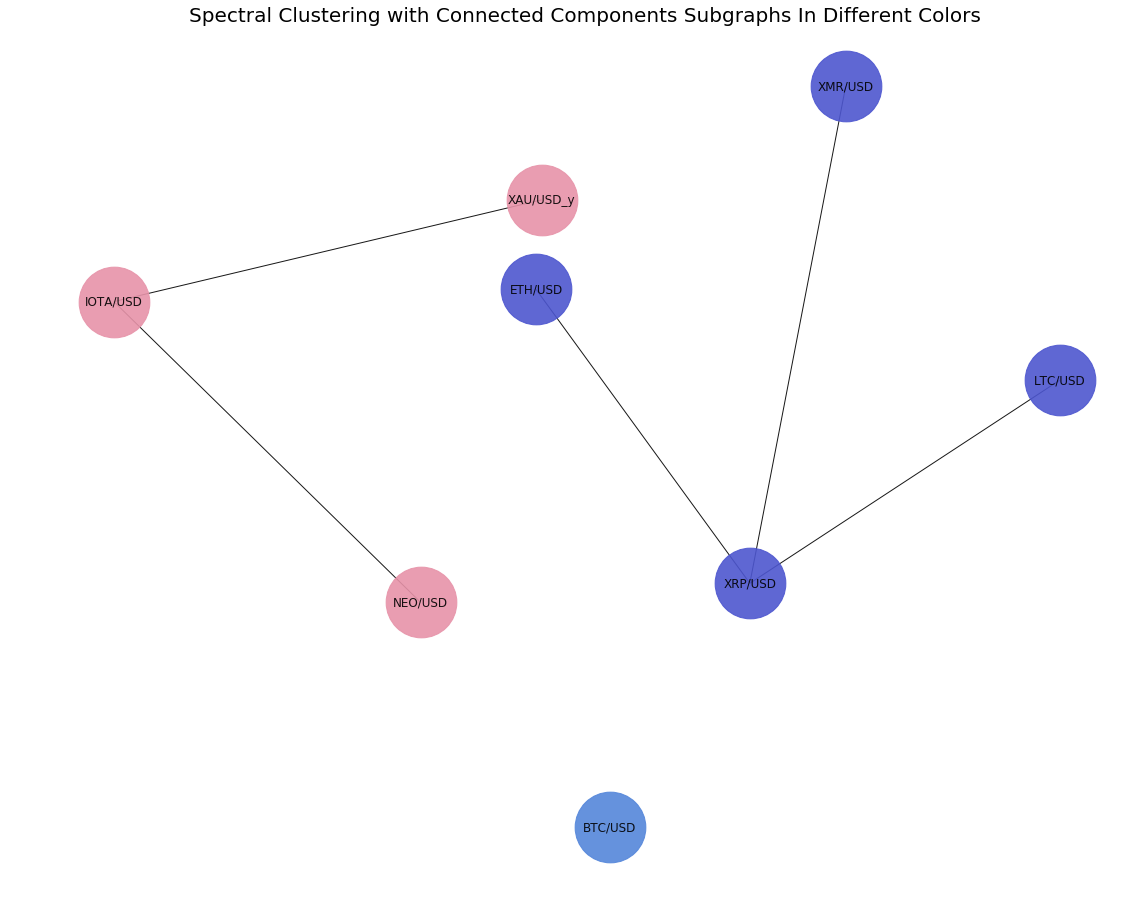

In [37]:
C = exch_logrets.corr()  # only for x/USD
#C[C.isna()] = 0  # still some NAs in data
D = np.sqrt(2 * (1 - C))
sc_mod = SpectralClustering(n_clusters=3, gamma=1.0, affinity='precomputed', assign_labels='kmeans')
clusters = sc_mod.fit_predict(D)


# Create Graph Dict From Clusters
M = dict()  # mapping dictionary
for jli in np.unique(clusters):
    ents = list(D.columns[clusters == jli])
    for jent in ents:
        if jent not in M:
            M[jent] = set([x for x in ents if x != jent])
        else:
            M[jent] |= set([x for x in ents if x != jent])

# Draw Graph (with subcomponents)
fig = plt.figure(figsize=(15, 12))
G = nx.Graph(M)
#nx.draw_networkx_nodes(M, pos)

C=nx.connected_component_subgraphs(G)
for g in C:
    c=[random.random()]*nx.number_of_nodes(g) # random color...
    pos = nx.kamada_kawai_layout(G)
    g = nx.minimum_spanning_tree(g)
    col = '#' + '%06X' % random.randint(0, 0xFFFFFF)
    nx.draw(g, pos, node_size=5000, edges=False,
         node_color=col, with_labels=True, alpha=.90)
plt.title("Spectral Clustering with Connected Components Subgraphs In Different Colors", 
         fontsize= 20)
plt.show();

Above I have done spectral clustering where the clusters are formed using the distance measure, $d_{X,Y}^B = \sqrt{2(1 - C_{X,Y}^B)}$. Once the clusters are formed they are visualized using the MST on each subgraph and colored accordingly. To me this provides a more reasonable graph than the thresholding method.

### Spectral Clustering with $D$ from Dynamic Time Warping (DTW)

I next want to try a distance measure that is a a slight modification to the $D$ the authors of the paper we have replicated have proposed. It isn't new but seems to work very well in the survey of time series dissimilarity measures paper. It is an elastic dissimilarity measure because it optimally aligns the time series temporally, e.g. it pulls them left or  right to better align with one another. It is computed recursively by the following:

$$
D_{i, j} = f(x_i, y_i) + \min\{D_{i,j-1}, D_{i-1,j}, D_{i-1,j-1}\}
$$

where $D_{0,0}=0$ and $i=1,...,N$ and $j=1,...,M$. In our case $M=N$ because we have balanced time series. $f$ is some dissimilarity measure, usually Euclidean distance, and that is what I go with. The final Distance is then,

$$
D_{DTW}(x,y) = D_{M,N}
$$

In [38]:
rng = range(exch_logrets.shape[1])
D_dtw = np.zeros((exch_logrets.shape[1], 
                  exch_logrets.shape[1]))
for i, j in zip(rng, rng):
    exch_logrets.iloc[:,i][exch_logrets.iloc[:,i].isnull()] = 0  # set NAs to zeros
    exch_logrets.iloc[:,j][exch_logrets.iloc[:,j].isnull()] = 0  # set NAs to zeros
    distance, path = fastdtw(np.array(exch_logrets.iloc[:,i]), 
                         np.array(exch_logrets.iloc[:,j]), 
                         dist=euclidean)
    D_dtw[i,j] = distance

/home/justin/.local/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


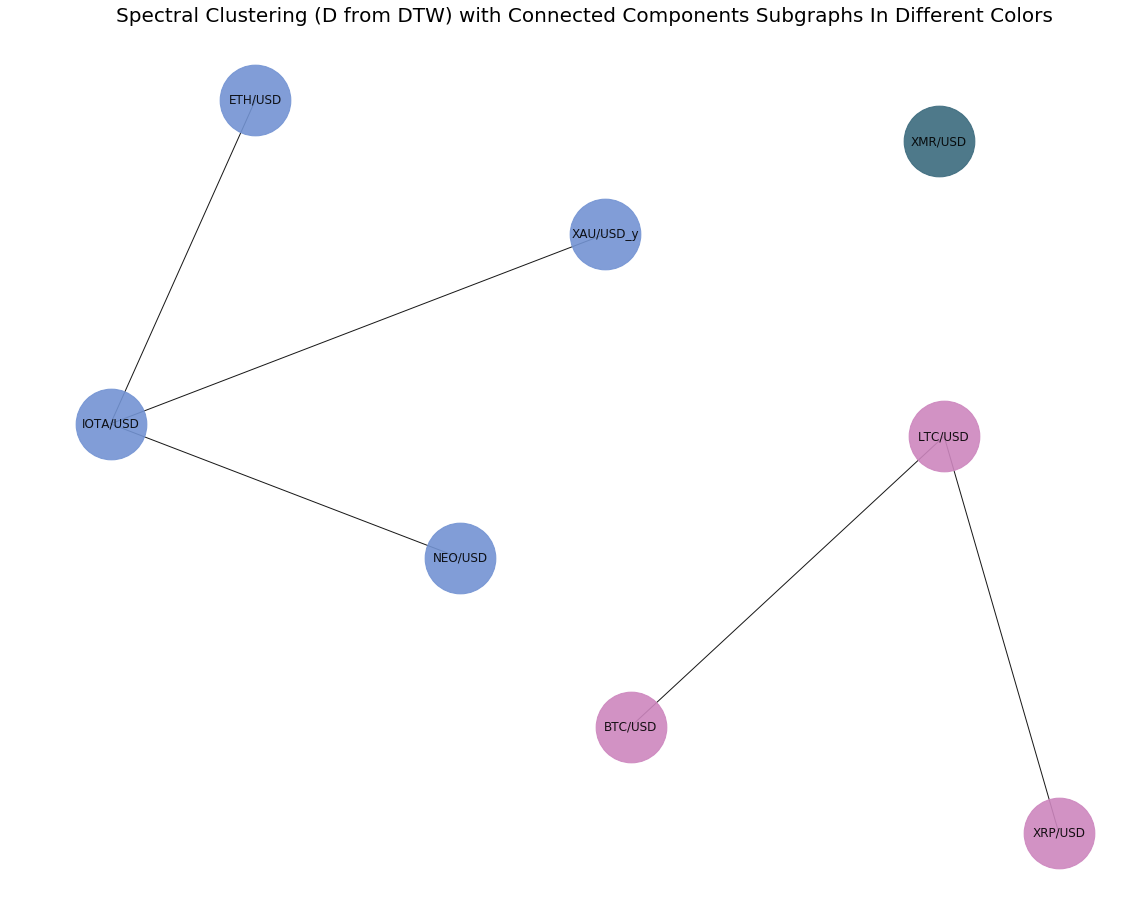

In [39]:
sc_mod = SpectralClustering(n_clusters=3, gamma=1.0, 
                   affinity='precomputed', assign_labels='kmeans')
clusters = sc_mod.fit_predict(D_dtw)

# Create Graph Dict From Clusters
M = dict()  # mapping dictionary
for jli in np.unique(clusters):
    ents = list(D.columns[clusters == jli])
    for jent in ents:
        if jent not in M:
            M[jent] = set([x for x in ents if x != jent])
        else:
            M[jent] |= set([x for x in ents if x != jent])

# Draw Graph (with subcomponents)
fig = plt.figure(figsize=(15, 12))
G = nx.Graph(M)

C=nx.connected_component_subgraphs(G)
for g in C:
    c=[random.random()]*nx.number_of_nodes(g) # random color...
    pos = nx.kamada_kawai_layout(G)
    g = nx.minimum_spanning_tree(g)
    col = '#' + '%06X' % random.randint(0, 0xFFFFFF)
    nx.draw(g, pos, node_size=5000, edges=False,
         node_color=col, with_labels=True, alpha=.90)
plt.title("Spectral Clustering (D from DTW) with Connected Components Subgraphs In Different Colors", 
         fontsize= 20)
plt.show();

__I am not impressed with this at all. We need a different distance measure!__

## Minimal Spanning Tree (MST)

They use MST in the paper for nothing other than making a graph easy to visualize and be interpretable. It doesn't give you antyhing besides telling you that for each node what is the closest node to it in distance. They define the distances as,

$$
d_{X,Y}^B = \sqrt{2(1 - C_{X,Y}^B)}.
$$

They also show the $\lambda_1$ for various bases over time (with a 6 month rolling window). We only have USD as a base so I just show that.

In [40]:
def window(seq, n=20*6):
    # 20 * 6 trading days in 6 months roughly
    # Returns a sliding window (of width n) over data from the iterable
    #   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...  
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

eigs_ovr_time = []
start_time = []
times = np.array(range(len(exch_logrets.index)))
for jwind in window(times):
    bools = np.logical_and(times >= jwind[0], 
                           times <= jwind[len(jwind)-1])
    C_temp = exch_logrets[bools].corr() 
    C_temp[C_temp.isnull()] = 0  # still some NAs in data
    eigvals_temp, eigvecs_temp = np.linalg.eig(C_temp)
    eigs_ovr_time.append(eigvals_temp.max())
    start_time.append(jwind[0])

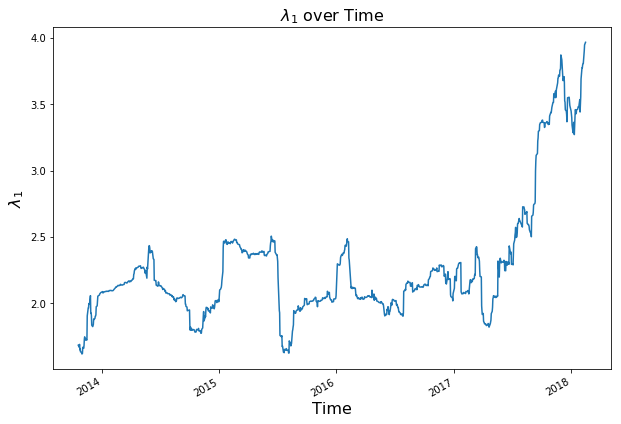

In [41]:
import matplotlib.dates as mdate
import datetime as dt

# Plot Eig 1 over Time
i = 0
dates = []
while i < len(eigs_ovr_time):
    dl = [int(x) for x in (exch_logrets.index[i]).split('/')]
    dates.append(dt.datetime(dl[2], dl[0], dl[1]))
    i += 1
x = list(dates)

plt.figure(figsize=(10, 7))
plt.plot(x, eigs_ovr_time);
plt.title('$\lambda_1$ over Time', fontsize=16)
plt.xlabel('Time', fontsize=16)
locator = mdate.YearLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.ylabel('$\lambda_1$', fontsize=16)
plt.show();

Looks similar to theirs! We can definetely see the decreasing independence over time! The USD is becoming less of a global reserve currency.


They show the MST for disparate time periods, 01/1999-12/2001 (Interval 1) and 07/2005-06/2008 (Interval 2). I'll do a similar thing and we can see how they change.

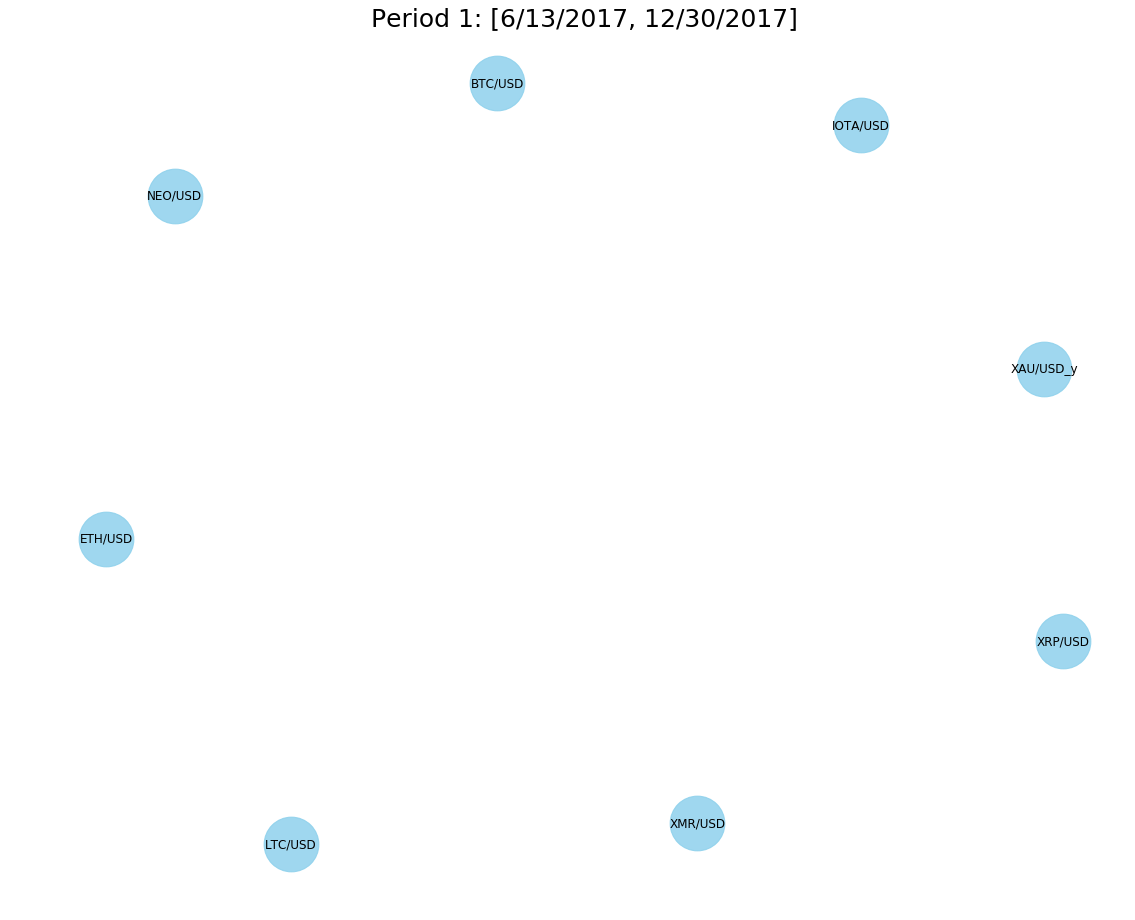

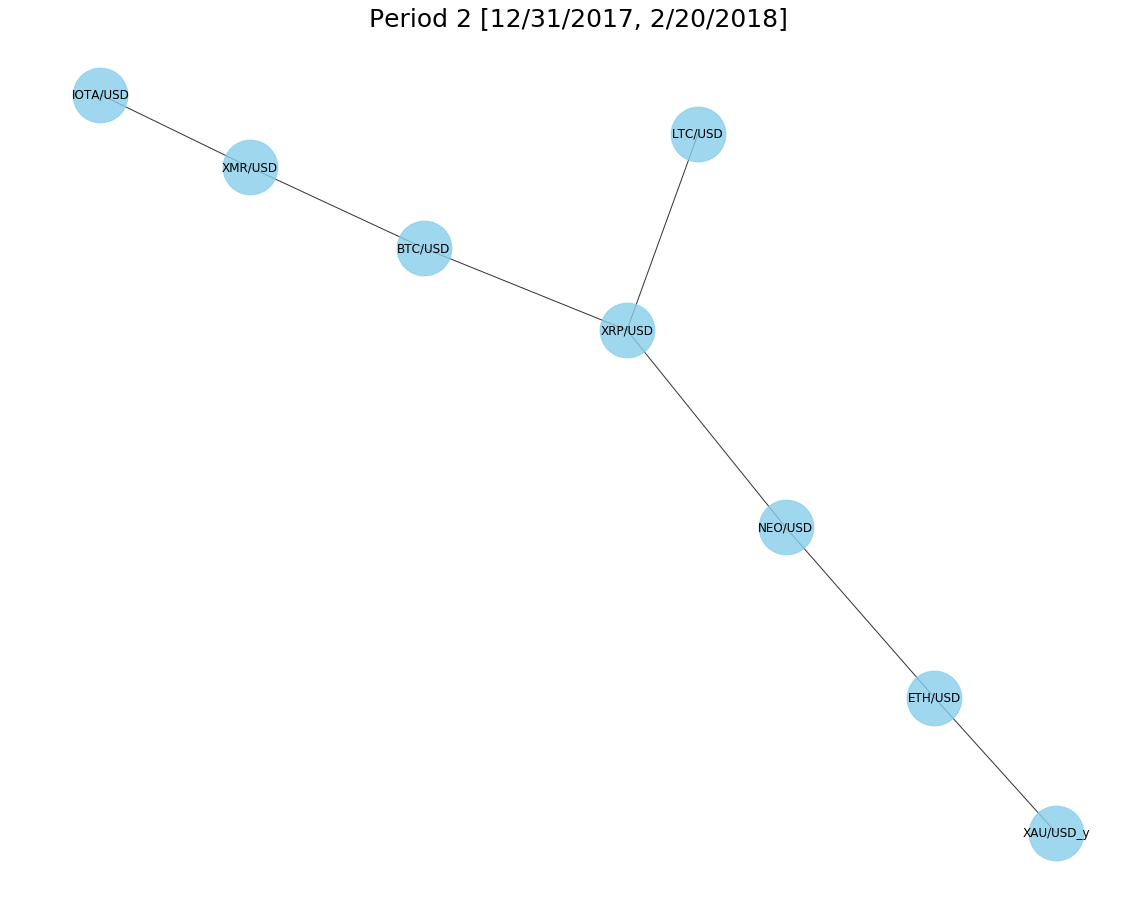

In [42]:
# Decide on two periods
start1 = '6/13/2017'
end1   = '12/30/2017'
start2 = '12/31/2017'
end2   = '2/20/2018'

# Period 1 Graph
bool1 = np.logical_and(exch_logrets.index >= start1, exch_logrets.index <= end1)
C = exch_logrets[bool1].corr()  # only for x/USD
#C[C.isna()] = 0  # still some NAs in data

D = np.sqrt(2 * (1 - C))
MST = minimum_spanning_tree(D) # cst object. NOT a distance matrix.
MST_matrix = MST.toarray()

labels={}
for j in range(len(D.columns)):
    labels[j] = D.columns[j]
    
fig = plt.figure(figsize=(15, 12))
G = nx.Graph(MST_matrix)
pos = nx.fruchterman_reingold_layout(G)
nx.draw(G, with_labels=False, node_size=3000, 
        node_color="skyblue", node_shape="o", 
        alpha=0.8, pos=pos)
nx.draw_networkx_labels(G,pos,labels)
plt.title("Period 1: [" + str(start1) + ", " + str(end1) + "]" ,
         fontsize=25)
plt.show()

# Period 2 Graph
bool2 = np.logical_and(exch_logrets.index >= start2, exch_logrets.index <= end2)
C = exch_logrets[bool2].corr()  # only for x/USD
#C[C.isna()] = 0  # still some NAs in data

D = np.sqrt(2 * (1 - C))
MST = minimum_spanning_tree(D) # cst object. NOT a distance matrix.
MST_matrix = MST.toarray()

labels={}
for j in range(len(D.columns)):
    labels[j] = D.columns[j]
    
fig = plt.figure(figsize=(15, 12))
G = nx.Graph(MST_matrix)
pos = nx.fruchterman_reingold_layout(G)
nx.draw(G, with_labels=False, node_size=3000, 
        node_color="skyblue", node_shape="o", 
        alpha=0.8, pos=pos)
nx.draw_networkx_labels(G,pos,labels)
plt.title("Period 2 [" + str(start2) + ", " + str(end2) + "]" ,
         fontsize=25)
plt.show()

## Hierarchical Clustering

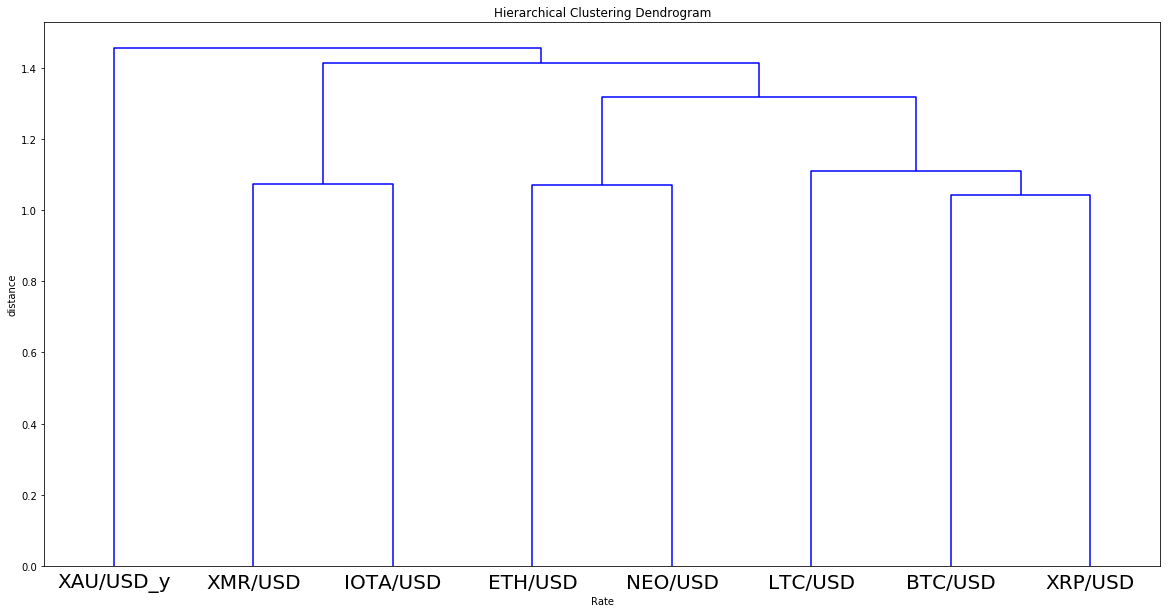

In [45]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(squareform(D), 'complete') # Linkage matrix.

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Rate')
plt.ylabel('distance')
dendrogram(Z, labels=D.columns, leaf_font_size=20)
plt.show()